In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

%matplotlib inline

from scipy.spatial.transform import Rotation as R  # for rotations
from scipy import linalg   # for eigenvalues 

import matplotlib.tri as tri

hour = 60*60.

In [2]:
### For looking at stress fields from outputs of mass and springs 

In [53]:
mdir = '../apophis5/'  # data directly
froot = 'd1cc'         # simulation output root 
shape_vol=1.98e+07     # for stress tensor , volume of shape model in m^3
t_datadump =900        # time between data dumps, half hour, in s
t0 = -hour*3           # time of first data dump w.r.t to perigee time 
iperi= int(-t0/t_datadump)     # which simulation index is at perigee
nsims = int(9*hour/t_datadump) # number of particle/spring outputs
t_list_hour = np.arange(t0/hour,tstop,t_datadump/hour)  # array of output times 
# from periceter in hours 

In [9]:
# read in springs file
def read_springs(mdir,froot,index):
    #springs[i].i, springs[i].j,
    # springs[i].ks, springs[i].rs0, springs[i].gamma, springs[i].k_heat
    sfname = mdir + froot + '_'+ iostring(index) + '_springs.txt'
    print(sfname)
    mtab = np.loadtxt(sfname)
    i_index = np.array(mtab[:,0], dtype=int)
    j_index = np.array(mtab[:,1], dtype=int)
    ks = mtab[0,2]  #all the same
    rs0 = mtab[:,3] # rest length, vector 
    ggamma = mtab[0,4] # all same 
    return i_index,j_index,ks,rs0,ggamma
    
# read in particles file
def read_particles(mdir,froot,index):
    # r->particles[i].x, r->particles[i].y, r->particles[i].z,
    #     r->particles[i].vx, r->particles[i].vy, r->particles[i].vz,
    #     r->particles[i].r, r->particles[i].m);
    sfname = mdir + froot + '_'+ iostring(index) + '_particles.txt'
    print(sfname)
    mtab = np.loadtxt(sfname,skiprows=1)
    xarr = mtab[:,0]
    yarr = mtab[:,1]
    zarr = mtab[:,2]
    vxarr = mtab[:,3]
    vyarr = mtab[:,4]
    vzarr = mtab[:,5]
    marr  = mtab[:,7]  
    return xarr,yarr,zarr,vxarr,vyarr,vzarr,marr

# file number manipulation
def iostring(index):
    junks = ''
    if (index < 10):
        junks += '0'
    if (index < 100):
        junks += '0'
    if (index < 1000):
        junks += '0'
    if (index < 10000):
        junks += '0'
    if (index < 100000):
        junks += '0'
    tstring = '{:d}'.format(index)
    junks += tstring
    #print(junks)
    return junks
    
#iostring(1)

# given a list of eigenvalues and eigenvectors of a 3x3 matrix, return a sorted list
# smallest eigenvalue first 
# also take real parts (assuming via a symmetric matrix)
def sort_eigs_3(w,v):
    jsort = np.argsort(w) # arguments/indices of a sorted array of eigenvalues, 
    # low to high
    jmax = jsort[2]  # index of maximum eigenvalue
    vmax = np.squeeze(np.asarray(v[:,jmax]))   # corresponding eigenvector
    jmin = jsort[0]
    vmin = np.squeeze(np.asarray(v[:,jmin]))   
    jmid = jsort[1]
    vmid = np.squeeze(np.asarray(v[:,jmid]))   
    eigmax = np.real(w[jmax])  #largest eigenvalue 
    eigmid = np.real(w[jmid])
    eigmin = np.real(w[jmin])
    wsort = np.array([eigmin,eigmid,eigmax])  # eigenvalues order smallest to largest  
    vsort = np.array([vmin,vmid,vmax])  # eigenvectors in same order 
    return wsort, vsort 



In [10]:
# store all simulation output info in a single class structure 
class sim_struct():
    def __init__(self,mdir,froot,index,shape_vol):
        self.index = index  # which output
        self.mdir  = mdir  # directory 
        self.froot = froot  # fileroot!
        self.isE = 0  # is there an Earth?
        self.read_spr()  # read in springs
        self.read_part() # read in  particles
        self.shape_vol = shape_vol   # shape model volume in m^3
        
    def read_spr(self):  # read springs from file
        i_index,j_index,ks,rs0,ggamma = read_springs(self.mdir,self.froot,self.index)
        self.i_index = i_index # spring connects particles i and j
        self.j_index = j_index
        self.rs0 = rs0  # is a vector, rest length 
        self.ks = ks  # is probably a single constant, spring constant
        self.ggamma = ggamma  # is probably a single constant, damping coefficient 
        
    def read_part(self): # read particles from file 
        xarr,yarr,zarr,vxarr,vyarr,vzarr,marr = read_particles(self.mdir,\
                                        self.froot,self.index)
        if (marr[-1] != marr[0]):
            self.ME = marr[-1] # EARTH
            self.posE = np.array([xarr[-1],yarr[-1],zarr[-1]])
            xarr = xarr[0:-1]
            yarr = yarr[0:-1]
            zarr = zarr[0:-1]
            marr = marr[0:-1]
            vxarr = vxarr[0:-1]
            vyarr = vyarr[0:-1]
            vzarr = vzarr[0:-1]
            print('Earth is present')
            self.isE=1
            
        self.pos = np.zeros((len(xarr),3))
        self.vel = np.zeros((len(xarr),3))
        self.pos[:,0] = xarr
        self.pos[:,1] = yarr
        self.pos[:,2] = zarr
        self.vel[:,0] = vxarr
        self.vel[:,1] = vyarr
        self.vel[:,2] = vzarr
        self.m = marr[0] #  assuming all the same mass 
        
    # compute stress tensor at each node by hand
    def compute_stress_tensor(self):  
        n_p = self.pos.shape[0]  #number of particles 
        #print(n_p)
        ns = len(self.i_index)   # number of springs 
        sigma = np.zeros((n_p,3,3))
        for k in range(ns): # loop over springs
            pi = self.i_index[k]  # spring connects particle pi to pj
            pj = self.j_index[k]
            Force,Lvec = self.spring_force_one(k)
            for i in range(3):
                for j in range(3):
                    sigma[pi,i,j] += Force[i]*Lvec[j]  
                    sigma[pj,i,j] += Force[i]*Lvec[j]
        nodevol = self.shape_vol/n_p  #  not 100% sure about normalization!
        self.sigma = sigma/nodevol # now has correct units 
        print('stress tensors computed')
        self.get_stress_eigs(); # compute the eigenvalues of the stress tensor
  
    # compute force and length vector for 1 spring k (used in computation of stress tensor)
    def spring_force_one(self,k):
        pi = self.i_index[k]
        pj = self.j_index[k]
        r_i = np.squeeze(self.pos[pi,:])
        r_j = np.squeeze(self.pos[pj,:])
        #print(r_i,r_j)
        dr = r_i - r_j  # is  a vector 
        L = np.sqrt(np.sum(dr*dr))  # current spring length 
        ks  = self.ks  # spring constant 
        rs0 = self.rs0[k]  # rest length 
        fac = -ks*(L-rs0)/L 
        Force = fac*dr 
        Lvec = dr 
    
        if (self.ggamma>0.0):   # damping force too!
            v_i = np.squeeze(self.vel[pi,:])
            v_j = np.squeeze(self.vel[pj,:])
            dv = v_i - v_j
            dLdt = np.sum(dr*dv)/L
                # divide dL/dt by L to get strain rate
            mbar = self.m/2; # reduced mass
            dampfac  = self.ggamma*mbar*dLdt/L;
               # factor L here to normalize dr
            Force -= dampfac*dr
    
        return Force, Lvec
    
    def rotate_to_sim(self,sim1): # rotate our simulation to the orientation of sim1
        q,rssd = R.align_vectors(sim1.pos, self.pos, weights=None)
        # https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.transform.Rotation.align_vectors.html#scipy.spatial.transform.Rotation.align_vectors
        # compute rotation transformation q by comparing two sets of points
        # uses Kabsch transform 
        rotated_pos = q.apply(self.pos) # transform second sim to first one's orientation!
        self.pos = rotated_pos # update positions 
        rotated_vel = q.apply(self.vel)  # transform velocities to new orientation 
        self.vel = rotated_vel
        self.q = q # store rotation 
        if (self.isE ==1): # also rotate the Earth's position!
            rotated_posE= q.apply(self.posE)
            self.posE = rotated_posE
        print('positions rotated')
        
    # get the eigenvalues of the stress tensor and their eigenvectors 
    def get_stress_eigs(self):
        n_p = self.pos.shape[0]  #number of particles 
        eigenvecs = self.sigma*0.0  # 3x3 matrix for each node 
        eigenvals = self.pos*0.0   # vector for each node
        for i in range(n_p):
            sig = np.squeeze(self.sigma[i,:,:]) # now 2d tensor
            w,v = linalg.eig(sig)  #compute eigenvalues and eigenvectors of stress tensor
            wsort,vsort = sort_eigs_3(w,v)  # sort the eigenvals and vecs big to little
            eigenvecs[i] = vsort
            eigenvals[i] = wsort 
        self.s_eigenvecs = eigenvecs
        self.s_eigenvals = eigenvals
        self.compute_J2()  # compute J2= invariant of deviatoric stress
        print('eigenvectors and eigenvalues of stress tensor computed')
        
    # compute sqrt J2 = invariant of deviatoric stress
    def compute_J2(self):   # after computing eigenvalues of stress tensor 
        s1 = np.squeeze(self.s_eigenvals[:,0])  
        s2 = np.squeeze(self.s_eigenvals[:,1])
        s3 = np.squeeze(self.s_eigenvals[:,2])
        self.sJ2 = np.sqrt(((s1-s2)**2 + (s1-s3)**2 + (s2-s3)**2)/6)

    # compute moment of inertia tensor and its eigenvalues and eigenvectors 
    def compute_mom_inertia(self):
        I = np.zeros((3,3))
        n_p = self.pos.shape[0]  #number of particles
        for k in range(n_p):
            for i in range(3):   #diagonal part 
                r2 = self.pos[k,0]**2 + self.pos[k,1]**2 + self.pos[k,2]**2
                I[i,i] += r2
            for i in range(3):   # including off diagonal part 
                for j in range(3):
                    I[i,j] -= self.pos[k,i]*self.pos[k,j]
        I*= self.m
        self.I = I 
        w,v = linalg.eig(I)
        wsort,vsort = sort_eigs_3(w,v)  # sort the eigenvals and vecs big to little
        self.I_eigenvals = wsort
        self.I_eigenvecs = vsort
        #print('moment of inertia computed')
        
    def rotate_to_principal(self):  # rotate to principal axis coordinate system
        #  compute_mom_inertia 
        self.compute_mom_inertia()  # compute moment of inertia along with its eigenvectors
        q =  R.from_matrix(self.I_eigenvecs) # create rotation from eigenvectors
        rotated_pos = q.apply(self.pos) # do rotation!
        self.pos = rotated_pos # update positions 
        rotated_vel = q.apply(self.vel)
        self.vel = rotated_vel
        self.q_I = q # store rotation 
        if (self.isE ==1): # also rotate the Earth's position!
            rotated_posE= q.apply(self.posE)
            self.posE = rotated_posE
        print('rotated to principal axis frame')
        self.compute_mom_inertia() #  recompute moments of inertia tensor
        
    def compute_L(self):   # compute angular momentum and spin vector 
        self.L = np.zeros(3)
        n_p = self.pos.shape[0]  #number of particles
        for i in range(n_p):  # compute spin angular momentum 
            rvec = np.squeeze(self.pos[i])
            vvec = np.squeeze(self.vel[i])
            dl = np.cross(rvec,vvec)*self.m  # sum over m(r x v)
            self.L += dl; 
        self.compute_mom_inertia()  # compute moment of inertia 
        I_inv = linalg.inv(self.I)  # invert moment of inertia 
        self.Omega = np.matmul(I_inv,self.L)  # compute spin vector 
        
    # compute spring lengths
    def compute_spring_lengths(self):
        ns = len(self.i_index)
        self.Larr = np.zeros(ns)
        for k in range(ns):  #loop over springs 
            pi = self.i_index[k]
            pj = self.j_index[k]
            r_i = np.squeeze(self.pos[pi,:])
            r_j = np.squeeze(self.pos[pj,:])
            dr = r_i - r_j  # is  a vector 
            L = np.sqrt(np.sum(dr*dr))  # current spring length 
            self.Larr[k] = L
        

In [11]:
# read in simulation outputs and put in a list
sim_list = []
for i in range(nsims):
    sim = sim_struct(mdir,froot,i,shape_vol)
    sim_list = np.append(sim_list,sim)

../apophis5/d1cc_000000_springs.txt
../apophis5/d1cc_000000_particles.txt
Earth is present
../apophis5/d1cc_000001_springs.txt
../apophis5/d1cc_000001_particles.txt
Earth is present
../apophis5/d1cc_000002_springs.txt
../apophis5/d1cc_000002_particles.txt
Earth is present
../apophis5/d1cc_000003_springs.txt
../apophis5/d1cc_000003_particles.txt
Earth is present
../apophis5/d1cc_000004_springs.txt
../apophis5/d1cc_000004_particles.txt
Earth is present
../apophis5/d1cc_000005_springs.txt
../apophis5/d1cc_000005_particles.txt
Earth is present
../apophis5/d1cc_000006_springs.txt
../apophis5/d1cc_000006_particles.txt
Earth is present
../apophis5/d1cc_000007_springs.txt
../apophis5/d1cc_000007_particles.txt
Earth is present
../apophis5/d1cc_000008_springs.txt
../apophis5/d1cc_000008_particles.txt
Earth is present
../apophis5/d1cc_000009_springs.txt
../apophis5/d1cc_000009_particles.txt
Earth is present
../apophis5/d1cc_000010_springs.txt
../apophis5/d1cc_000010_particles.txt
Earth is present

In [15]:
sim_list[0].rotate_to_principal() # rotate first simulation to principal axis 
for i in range(1,nsims):
    sim_list[i].rotate_to_sim(sim_list[0])   # rotate rest to same orientation as first one
for i in range(0,nsims):
    sim_list[i].compute_stress_tensor()  # compute stress tensor for all of them 
    sim_list[i].compute_L()  # compute spin

rotated to principal axis frame
positions rotated
positions rotated
positions rotated
positions rotated
positions rotated
positions rotated
positions rotated
positions rotated
positions rotated
positions rotated
positions rotated
positions rotated
positions rotated
positions rotated
positions rotated
positions rotated
positions rotated
positions rotated
positions rotated
positions rotated
positions rotated
positions rotated
positions rotated
positions rotated
positions rotated
positions rotated
positions rotated
positions rotated
positions rotated
positions rotated
positions rotated
positions rotated
positions rotated
positions rotated
positions rotated
stress tensors computed
eigenvectors and eigenvalues of stress tensor computed
stress tensors computed
eigenvectors and eigenvalues of stress tensor computed
stress tensors computed
eigenvectors and eigenvalues of stress tensor computed
stress tensors computed
eigenvectors and eigenvalues of stress tensor computed
stress tensors compute

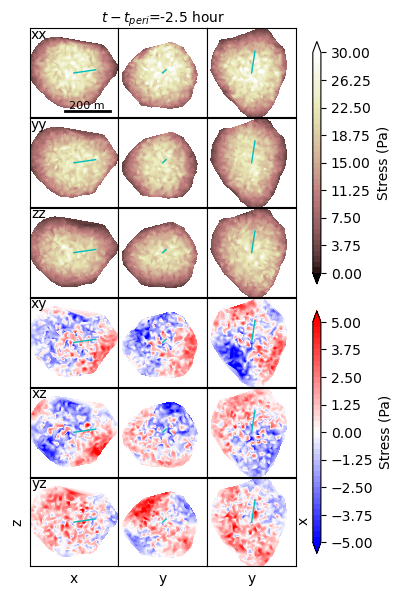

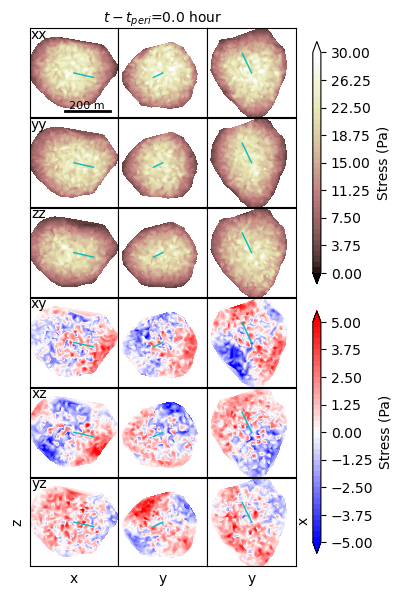

In [54]:
def plt_sig6(sim,sim1,subit,vmin,vmax,vmin2,vmax2,tlabel,ofile):
    fig, axarr = plt.subplots(6,3,figsize=(4.3,7),sharex=True,sharey=True,dpi=100)
    plt.subplots_adjust(wspace=0,hspace=0)
    
    width = 20.   #could be adjusted choose a width of plane to contain points 
    min_circle_ratio=0.03 # helps with tricontour concavity 
    
    dE = np.sqrt(np.sum(sim.posE*sim.posE))
    Evec = sim.posE/dE * 100.0 # to display Earth direction 
    
    pos = sim.pos
    if (subit==1):
        sigma= sim.sigma  - sim1.sigma  # subtract out first one 
        #cmap_e =  mpl.cm.bwr; cmap_e.set_under('blue'); cmap_e.set_over('red')
    else:
        sigma = sim.sigma #- sim1.sigma
        #cmap_e =  mpl.cm.pink; cmap_e.set_under('black'); cmap_e.set_over('white')
    
    for i in range(6):
        for j in range(3):
            axarr[i,j].set_aspect('equal')
    
    axarr[0,0].set_xlim([-199,200])
    axarr[0,0].set_ylim([-199,200])
    axarr[0,0].set_xticks([])
    axarr[0,0].set_yticks([])

    for k in range(6):

        if (k==0):
            i=0; j=0; sig_str = 'xx'
        if (k==1):
            i=1; j=1; sig_str = 'yy'
        if (k==2):
            i=2; j=2; sig_str = 'zz'
        if (k==3):
            i=0; j=1; sig_str = 'xy'
        if (k==4):
            i=0; j=2; sig_str = 'xz'
        if (k==5):
            i=1; j=2; sig_str = 'yz'
         
        cmap_e =  mpl.cm.bwr; cmap_e.set_under('blue'); cmap_e.set_over('red')
        if (k <3):
            levs = np.linspace(int(vmin),int(vmax), 41)
            if (subit==0):
                cmap_e =  mpl.cm.pink; cmap_e.set_under('black'); cmap_e.set_over('white')
        else:
            levs = np.linspace(int(vmin2),int(vmax2), 41)
            #cmap_e =  mpl.cm.bwr; cmap_e.set_under('blue'); cmap_e.set_over('red')
            
        xl=-156;yl=172
        axarr[k,0].text(xl,yl,sig_str,fontsize=10,ha='center',va='center')
            
        ypos = np.squeeze(pos[:,1])  
        ii = (np.abs(ypos)<width) # restrict to near y=0
        x = pos[ii,0]; y = pos[ii,1]; z = pos[ii,2]
        triang = tri.Triangulation(x, z)
        mask = tri.TriAnalyzer(triang).get_flat_tri_mask(min_circle_ratio)
        triang.set_mask(mask)
        axarr[k,0].tricontourf(triang,sigma[ii,i,j],levels=levs,cmap=cmap_e,extend='both')

        xpos = np.squeeze(pos[:,0])
        ii = (np.abs(xpos)<width) # restrict to near x=0
        x = pos[ii,0]; y = pos[ii,1]; z = pos[ii,2]
        triang = tri.Triangulation(y, z)
        mask = tri.TriAnalyzer(triang).get_flat_tri_mask(min_circle_ratio)
        triang.set_mask(mask)
        axarr[k,1].tricontourf(triang,sigma[ii,i,j],levels=levs,cmap=cmap_e,extend='both')
        
        zpos = np.squeeze(pos[:,2])
        ii = (np.abs(zpos)<width) # restrict to near z=0
        x = pos[ii,0]; y = pos[ii,1]; z = pos[ii,2]
        triang = tri.Triangulation(y, x)
        mask = tri.TriAnalyzer(triang).get_flat_tri_mask(min_circle_ratio)
        triang.set_mask(mask)
        im=axarr[k,2].tricontourf(triang,sigma[ii,i,j],levels=levs,cmap=cmap_e,extend='both')
        
        if (k==0):
            cbar = plt.colorbar(im,ax=axarr[0:3,:],shrink=0.9,aspect=30,label='Stress (Pa)')
        if (k==3):   
            cbar = plt.colorbar(im,ax=axarr[3:6,:],shrink=0.9,aspect=30,label='Stress (Pa)')
    
    for k in range(6): # show a segment pointing toward Earth
        axarr[k,0].plot([0,Evec[0]],[0,Evec[2]],'c-',lw=1)  # point toward the Earth!
        axarr[k,1].plot([0,Evec[1]],[0,Evec[2]],'c-',lw=1)
        axarr[k,2].plot([0,Evec[1]],[0,Evec[0]],'c-',lw=1)
    
    axarr[5,0].set_ylabel('z')
    axarr[5,0].set_xlabel('x')
    axarr[5,1].set_xlabel('y')
    axarr[5,2].set_xlabel('y')
    axarr[5,2].text(200,0,'x',rotation='vertical')
    #ax_r = axarr[5,2].twinx() bombs
    #ax_r.set_ylabel('y')
    
    x0=-40; y0=-170.0; x1 = x0+200.0;
    axarr[0,0].plot([x0,x1],[y0,y0],'k-',lw=2)
    axarr[0,0].text((x0+x1)/2,y0,'200 m',ha='center',va='bottom',fontsize=8)
    # show scale bar 
    
    tlabel_full = r'$t-t_{peri}$=' + tlabel + ' hour'
    axarr[0,1].text(0,240,tlabel_full,ha='center',va='center')
    
    if (len(ofile)>3):
        plt.savefig(ofile,dpi=200)

j=2;       tlabel ='{:.1f}'.format(t_list_hour[j])
plt_sig6(sim_list[j],sim_list[0],0,0,30,-5,5,tlabel,'')
j = iperi; tlabel ='{:.1f}'.format(t_list_hour[j])
plt_sig6(sim_list[j],sim_list[0],0,0,30,-5,5,tlabel,'')

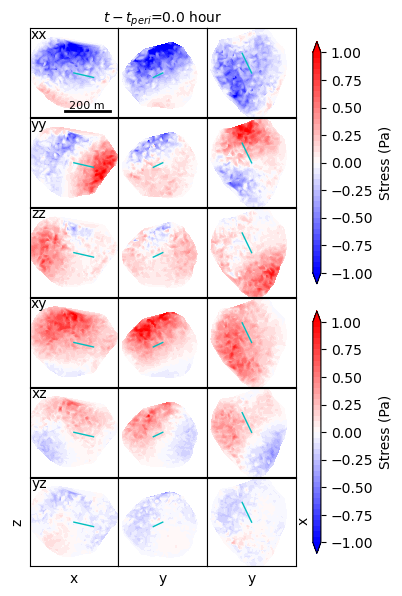

In [55]:
j = iperi; tlabel ='{:.1f}'.format(t_list_hour[j])
plt_sig6(sim_list[j],sim_list[0],1,-1.5,1.5,-1.5,1.5,tlabel,'')

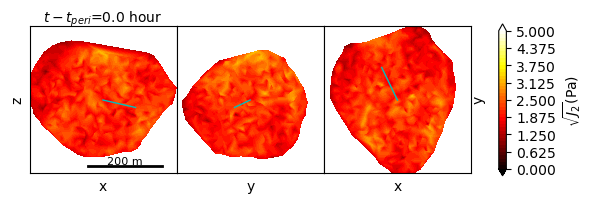

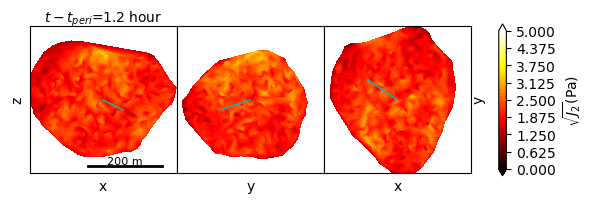

In [56]:
def plt_J2(sim,sim1,subit,vmin,vmax,tlabel,ofile):
    fig, axarr = plt.subplots(1,3,figsize=(6,2),sharex=True,sharey=True)
    plt.subplots_adjust(wspace=0,hspace=0,left=0.04,right=0.96,top=0.99,bottom=0.04)
    pos= sim.pos 
    if (subit==1):
        sJ2 = sim.sJ2 - sim1.sJ2
        #cmap_b =  mpl.cm.BrBG; cmap_b.set_under('brown'); cmap_b.set_over('green')
        # create nice colormap
        top = mpl.colormaps['BuGn_r'].resampled(128)
        bottom = mpl.colormaps['YlOrRd'].resampled(128)
        newcolors = np.vstack((top(np.linspace(0, 1, 128)),\
                       bottom(np.linspace(0, 1, 128))))
        cmap_b = mpl.colors.ListedColormap(newcolors, name='BuGnYlOrRd')
        cmap_b.set_under('green'); cmap_b.set_over('red')  # extend it
    else:
        sJ2 = np.sqrt(sim.sJ2)
        cmap_b =  mpl.cm.hot;  cmap_b.set_under('black'); cmap_b.set_over('white')
        # extended 
        
    axarr[0].set_xlim([-199,200])
    axarr[0].set_ylim([-199,200])
    axarr[0].set_xticks([])
    axarr[0].set_yticks([])
    
    width = 20.   # width of plane containing points that are plotted
    min_circle_ratio=0.03 # helps with concavity in triangulation 
    axarr[0].set_aspect('equal')
    axarr[1].set_aspect('equal')
    axarr[2].set_aspect('equal')
    levs  = np.linspace(int(vmin),int(vmax),41)
    
    dE = np.sqrt(np.sum(sim.posE*sim.posE)) # Earth!
    Evec = sim.posE/dE * 100.0 
    
    ypos = np.squeeze(pos[:,1])
    ii = (np.abs(ypos)<width)
    x = np.squeeze(pos[ii,0]); y = np.squeeze(pos[ii,1]); z = np.squeeze(pos[ii,2])
    triang = tri.Triangulation(x, z)
    mask = tri.TriAnalyzer(triang).get_flat_tri_mask(min_circle_ratio)
    triang.set_mask(mask)
    axarr[0].tricontourf(triang,sJ2[ii],levels=levs,cmap=cmap_b,extend='both')
    axarr[0].plot([0,Evec[0]],[0,Evec[2]],'c-',lw=1) # Earth
    
    xpos = np.squeeze(pos[:,0])
    ii = (np.abs(xpos)<width)
    x = np.squeeze(pos[ii,0]); y = np.squeeze(pos[ii,1]); z = np.squeeze(pos[ii,2])
    triang = tri.Triangulation(y, z)
    mask = tri.TriAnalyzer(triang).get_flat_tri_mask(min_circle_ratio)
    triang.set_mask(mask)
    axarr[1].tricontourf(triang,sJ2[ii],levels=levs,cmap=cmap_b,extend='both')
    axarr[1].plot([0,Evec[1]],[0,Evec[2]],'c-',lw=1)
    
    zpos = np.squeeze(pos[:,2])
    ii = (np.abs(zpos)<width)
    x = np.squeeze(pos[ii,0]); y = np.squeeze(pos[ii,1]); z = np.squeeze(pos[ii,2])
    triang = tri.Triangulation(y, x)
    mask = tri.TriAnalyzer(triang).get_flat_tri_mask(min_circle_ratio)
    triang.set_mask(mask)
    im= axarr[2].tricontourf(triang,sJ2[ii],levels=levs,cmap=cmap_b,extend='both')
    axarr[2].plot([0,Evec[1]],[0,Evec[0]],'c-',lw=1)

    cstring = r'$\sqrt{J_2}$(Pa)'
    if (subit==1):
        cstring = r'$\Delta$' + cstring
        
    plt.colorbar(im,ax=axarr,shrink=0.8,label=cstring)
    
    x0=-40; y0=-180.0; x1 = x0+200.0;
    axarr[0].plot([x0,x1],[y0,y0],'k-',lw=2)  # put a 200 m bar on the plot
    axarr[0].text((x0+x1)/2,y0,'200 m',ha='center',va='bottom',fontsize=8)
    axarr[0].set_ylabel('z')
    axarr[0].set_xlabel('x')
    axarr[1].set_xlabel('y')
    axarr[2].set_xlabel('x')
    axarr[2].text(200,0,'y',rotation='vertical')
    
    tlabel_full = r'$t-t_{peri}$=' + tlabel + ' hour'
    axarr[0].text(0,220,tlabel_full,ha='center',va='center')
    
    if (len(ofile)>3):
        plt.savefig(ofile,dpi=300)

zl = 0.; zh = 5
j=iperi; tlabel ='{:.1f}'.format(t_list_hour[j])
plt_J2(sim_list[j],sim_list[0],0,zl,zh,tlabel,'')
j=iperi+5; tlabel ='{:.1f}'.format(t_list_hour[j])
plt_J2(sim_list[j],sim_list[0],0,zl,zh,tlabel,'')


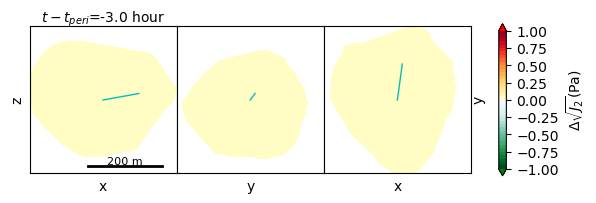

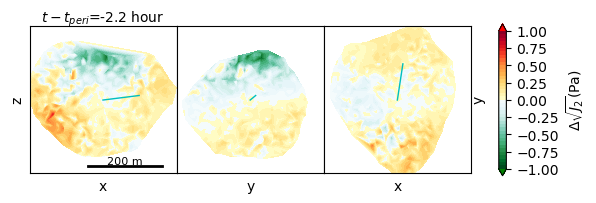

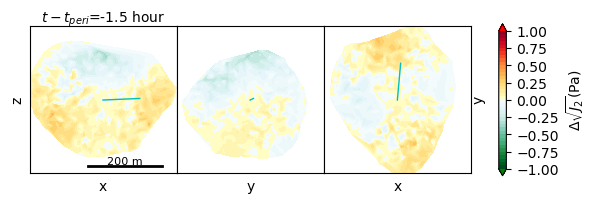

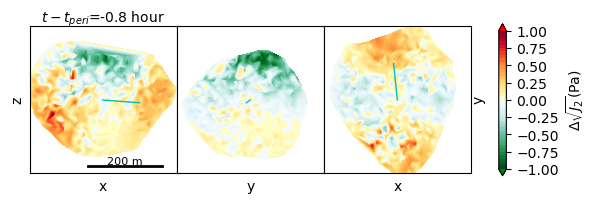

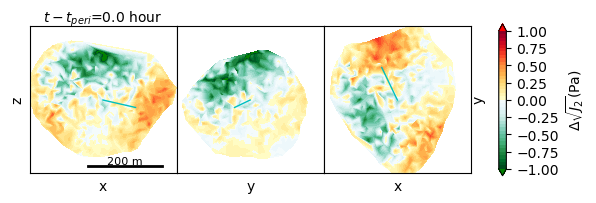

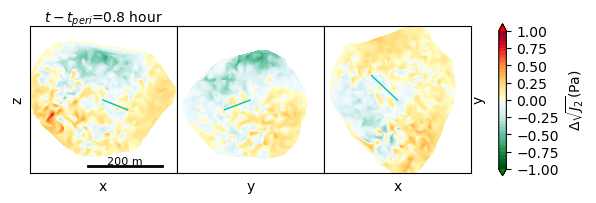

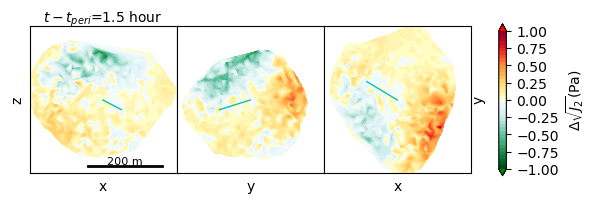

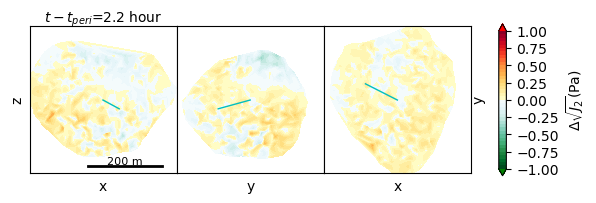

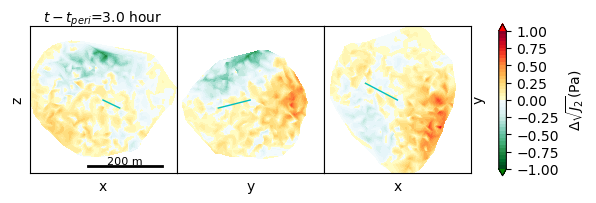

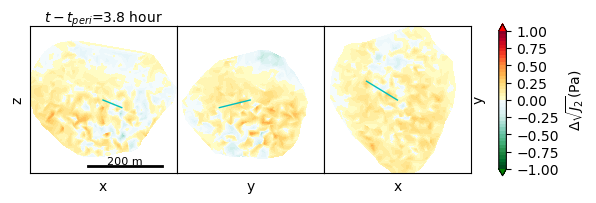

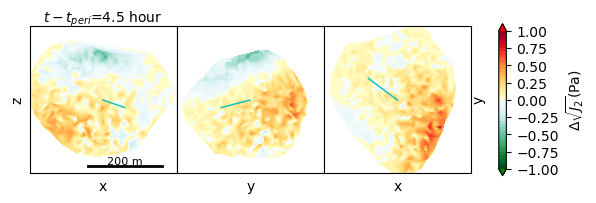

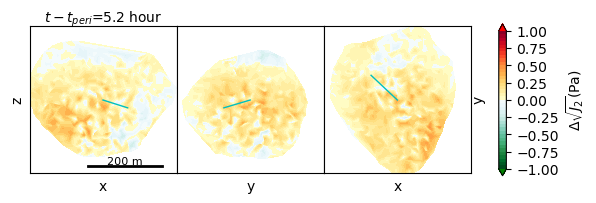

In [57]:
zl = -1.0
zh = 1.0
#plt_J2(sim_1 ,sim_1,0,zl,zh,'')
for i in range(0,nsims,3):
    jstr = '{:d}'.format(i) #froot + '_0_J2.png'
    if (i<10):
        jstr = '0' + jstr
    ofile = froot + '_' + jstr + '_' + 'J2.png'
    #print(ofile)
    tlabel ='{:.1f}'.format(t_list_hour[i])
    plt_J2(sim_list[i] ,sim_list[0],1,zl,zh,tlabel,ofile)
    

Text(0.5, 0, '$t - t_{peri}$ (hour)')

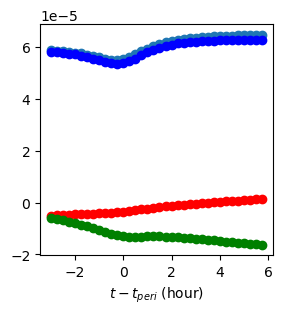

In [41]:
# let's look at the spin vector 
Omega_list = np.zeros((nsims,3))
Om_mag = np.zeros(nsims)
for i in range(nsims):
    Omega_list[i] = np.squeeze(sim_list[i].Omega)
    Om_mag[i] = np.sqrt(np.sum(sim_list[i].Omega**2))
    
tstop = nsims*t_datadump/hour + t0/hour
t_list_hour = np.arange(t0/hour,tstop,t_datadump/hour)

fig,ax = plt.subplots(1,1,figsize=(3,3))
ax.plot(t_list,Om_mag,'o')
ax.plot(t_list_hour,-Omega_list[:,0],'ro') # magnitudes so easier to see on same plot
ax.plot(t_list_hour,Omega_list[:,1],'go')
ax.plot(t_list_hour,-Omega_list[:,2],'bo')
ax.set_xlabel(r'$t - t_{peri}$ (hour)')

In [42]:
# save omega information so could be read in later!
outfile = froot + '_om.npz'
np.savez(outfile, t_list, Om_mag)

In [104]:
# looking at spring strain distributions 
sim_list[6].compute_spring_lengths()
sim_list[0].compute_spring_lengths()
strain6= (sim_list[6].Larr - sim_list[6].rs0)/sim_list[6].rs0
strain0= (sim_list[0].Larr - sim_list[0].rs0)/sim_list[0].rs0

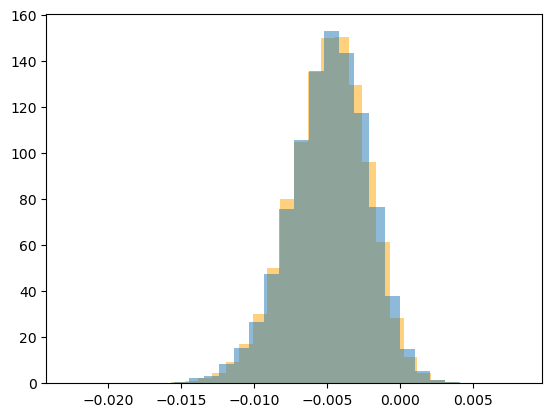

In [114]:
plt.hist(strain6,alpha=0.5,bins=30,color='orange',density=True)
junk=plt.hist(strain0,alpha=0.5,bins=30,density=True)
# original strain distribution is slightly narrower than during encounter 

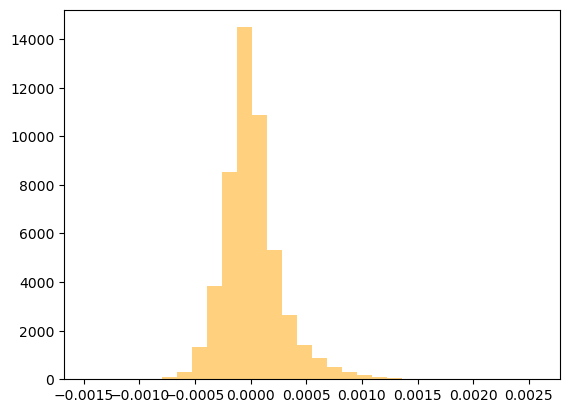

In [116]:
junk=plt.hist(strain6-strain0,bins=30,alpha=0.5,color='orange')
# size of change in strain is maybe 1/4 percent?

In [100]:
ii = np.argmax(sim_list[6].J2-sim_list[0].J2)
print(ii,sim_list[6].pos[ii])
ii = np.argmin(sim_list[6].J2-sim_list[0].J2)
print(ii,sim_list[6].pos[ii])

1722 [-124.6188253    72.03420867  -13.44659885]
1907 [76.54579118 52.99569246 76.36333716]
